In [ ]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [ ]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                 std=[0.2470, 0.2435, 0.2616])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    normalize,
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
    ])

In [ ]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13044515.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


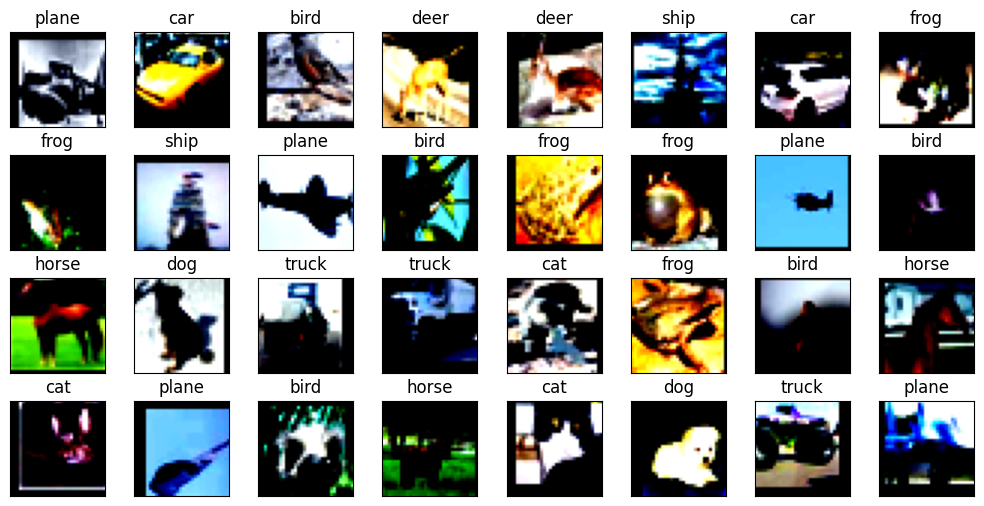

In [ ]:
import matplotlib.pyplot as plt

xb, yb = next(iter(train_loader))

row_num, col_num = int(BATCH_SIZE/8), 8
fig, axs = plt.subplots(row_num, col_num, figsize=(10, 10 * row_num/col_num))

for row_idx in range(row_num):
    for col_idx in range(col_num):
        ax = axs[row_idx][col_idx]
        i = col_idx * row_num + row_idx

        class_index = yb[i].item()
        class_label = classes[class_index].split(",")[0]
        img = xb[i].permute(1,2,0)
        img = np.clip(img.cpu().numpy() * 255, 0, 255).astype(np.uint8)

        ax.title.set_text(class_label)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(img)

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [ ]:
class Residual(nn.Module):
    def __init__(self, residual, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = residual
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

In [ ]:
class NormAct(nn.Sequential):
    def __init__(self, channels):
        super().__init__(
            nn.BatchNorm2d(channels),
            nn.SiLU(inplace=True)
        )

In [ ]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            NormAct(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
        )

In [ ]:
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduced_channels):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(reduced_channels, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

In [ ]:
class MBConvResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, expansion, kernel_size=3, stride=1):
        mid_channels = in_channels * expansion
        squeeze_channels = in_channels // 4
        super().__init__(
            ConvBlock(in_channels, mid_channels, 1), # Pointwise
            ConvBlock(mid_channels, mid_channels, kernel_size, stride=stride, groups=mid_channels), # Depthwise
            NormAct(mid_channels),
            SqueezeExciteBlock(mid_channels, squeeze_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1) # Pointwise
        )

In [ ]:
class MBConvBlock(Residual):
    def __init__(self, in_channels, out_channels, expansion, kernel_size=3, stride=1):
        residual = MBConvResidual(in_channels, out_channels, expansion, kernel_size, stride)
        shortcut = self.get_shortcut(in_channels, out_channels, stride)
        super().__init__(residual, shortcut)

    def get_shortcut(self, in_channels, out_channels, stride):
        if in_channels != out_channels:
            shortcut = nn.Conv2d(in_channels, out_channels, 1)
            if stride > 1:
                shortcut = nn.Sequential(nn.AvgPool2d(stride), shortcut)
        elif stride > 1:
            shortcut = nn.AvgPool2d(stride)
        else:
            shortcut = nn.Identity()
        return shortcut

In [ ]:
class BlockStack(nn.Sequential):
    def __init__(self, num_layers, channel_list, strides, expansion=4, kernel_size=3):
        layers = []
        for num, in_channels, out_channels, stride in zip(num_layers, channel_list, channel_list[1:], strides):
            for _ in range(num):
                layers.append(MBConvBlock(in_channels, out_channels, expansion, kernel_size, stride))
                in_channels = out_channels
                stride = 1
        super().__init__(*layers)

In [ ]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, mult=4, p_drop=0.):
        mid_channels = in_channels * mult
        super().__init__(
            ConvBlock(in_channels, mid_channels, 1),
            NormAct(mid_channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(mid_channels, classes)
        )

In [ ]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, mid_channels, out_channels, stride):
        squeeze_channels = mid_channels // 4
        super().__init__(
            nn.Conv2d(in_channels, mid_channels, 3, stride=stride, padding=1),
            ConvBlock(mid_channels, mid_channels, 3, groups=mid_channels), # Depthwise
            NormAct(mid_channels),
            SqueezeExciteBlock(mid_channels, squeeze_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1) # Pointwise
        )

In [ ]:
class EfficientNet(nn.Sequential):
    def __init__(self, classes,  num_layers, channel_list, strides, expansion=4,
                 in_channels=3, head_p_drop=0.):
        super().__init__(
            Stem(in_channels, *channel_list[:2], stride=strides[0]),
            BlockStack(num_layers, channel_list[1:], strides[1:], expansion),
            Head(channel_list[-1], classes, p_drop=head_p_drop)
        )

In [ ]:
model = EfficientNet(NUM_CLASSES,
                     num_layers =            [4,  4,   4,   4],
                     channel_list = [32, 16, 32, 64, 128, 256],
                     strides =           [1,  1,  2,   2,   2],
                     expansion = 4,
                     head_p_drop = 0.3)

model.apply(init_linear)
model.to(device)
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 3,351,478


In [ ]:
# @title Trainer & Evaluator
import time
import numpy as np
import torch

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite

from sklearn.metrics import classification_report

# Define a function to train the model with specified parameters
def train_model(model, train_loader, test_loader, optimizer, loss_fn, lr_scheduler, device, max_epochs=100, patience_limit=10):
    epoch_times = []
    best_val_acc = 0.0
    patience_counter = 0
    best_model_weights = None
    best_epoch = 0

    # Initialize history to track metrics
    history = defaultdict(list)

    trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
    trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step())

    ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

    val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}
    evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

    @trainer.on(Events.EPOCH_STARTED)
    def start_epoch_timer(engine):
        engine.state.epoch_start_time = time.time()

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(engine):
        nonlocal best_val_acc, patience_counter, best_model_weights, best_epoch

        # Calculate epoch time
        epoch_time = time.time() - engine.state.epoch_start_time
        epoch_times.append(epoch_time)

        train_state = engine.state
        epoch = train_state.epoch
        max_epochs = train_state.max_epochs
        train_loss = train_state.metrics["loss"]

        # Log history
        history['train loss'].append(train_loss)

        evaluator.run(test_loader)
        val_metrics = evaluator.state.metrics
        val_loss = val_metrics["loss"]
        val_acc = val_metrics["accuracy"]

        # Log validation history
        history['val loss'].append(val_loss)
        history['val acc'].append(val_acc)

        print("{}/{} - train: loss {:.3f}; val: loss {:.3f}, accuracy {:.3f}, time {:.2f}s".format(
            epoch, max_epochs, train_loss, val_loss, val_acc, epoch_time))

        # Check for improvement in validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = model.state_dict()  # Save the model weights
            best_epoch = epoch
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Check if patience limit has been reached
        if patience_counter >= patience_limit:
            print("Early stopping: No improvement for {} epochs.".format(patience_limit))
            trainer.terminate()  # Stop training

    @trainer.on(Events.COMPLETED)
    def log_total_training_time(engine):
        total_time = sum(epoch_times)
        print(f"Total training time: {total_time:.2f}s")

        # Load the best model weights
        model.load_state_dict(best_model_weights)

        # Calculate predictions for classification report
        model.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                all_preds.append(preds)
                all_labels.append(labels)

        # Convert lists to tensors
        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        # Print classification report
        print("Classification Report:")
        print(classification_report(all_labels, all_preds))

        # Plot training and validation loss
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xs = np.arange(1, len(history['train loss']) + 1)
        ax.plot(xs, history['train loss'], '.-', label='train')
        ax.plot(xs, history['val loss'], '.-', label='val')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid()
        plt.title("Training and Validation Loss")
        plt.show()

        # Plot validation accuracy
        fig = plt.figure()
        ax = fig.add_subplot(111)
        xs = np.arange(1, len(history['val acc']) + 1)
        ax.plot(xs, history['val acc'], '-')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Validation Accuracy')
        ax.grid()
        plt.title("Validation Accuracy")
        plt.show()

    # Run the trainer
    trainer.run(train_loader, max_epochs=max_epochs)

1/100 - train: loss 1.081; val: loss 0.974, accuracy 0.654, time 68.21s
2/100 - train: loss 0.775; val: loss 0.699, accuracy 0.755, time 68.03s
3/100 - train: loss 0.700; val: loss 0.605, accuracy 0.794, time 67.86s
4/100 - train: loss 0.611; val: loss 0.559, accuracy 0.807, time 68.85s
5/100 - train: loss 0.541; val: loss 0.530, accuracy 0.817, time 68.41s
6/100 - train: loss 0.508; val: loss 0.501, accuracy 0.830, time 68.34s
7/100 - train: loss 0.490; val: loss 0.505, accuracy 0.830, time 69.79s
8/100 - train: loss 0.493; val: loss 0.470, accuracy 0.843, time 69.79s
9/100 - train: loss 0.473; val: loss 0.476, accuracy 0.840, time 69.07s
10/100 - train: loss 0.504; val: loss 0.495, accuracy 0.831, time 69.04s
11/100 - train: loss 0.438; val: loss 0.498, accuracy 0.836, time 68.70s
12/100 - train: loss 0.450; val: loss 0.482, accuracy 0.845, time 69.13s
13/100 - train: loss 0.448; val: loss 0.507, accuracy 0.830, time 69.59s
14/100 - train: loss 0.451; val: loss 0.483, accuracy 0.847,

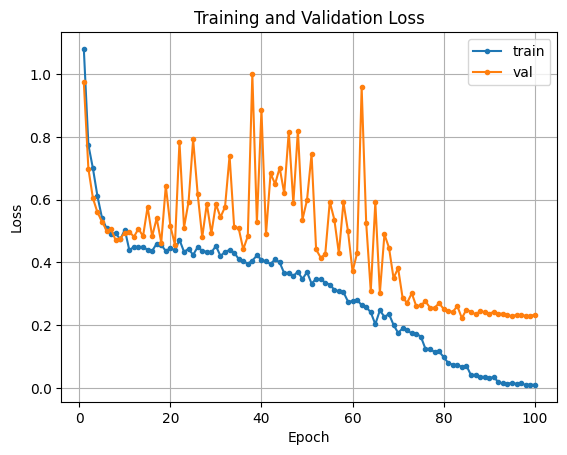

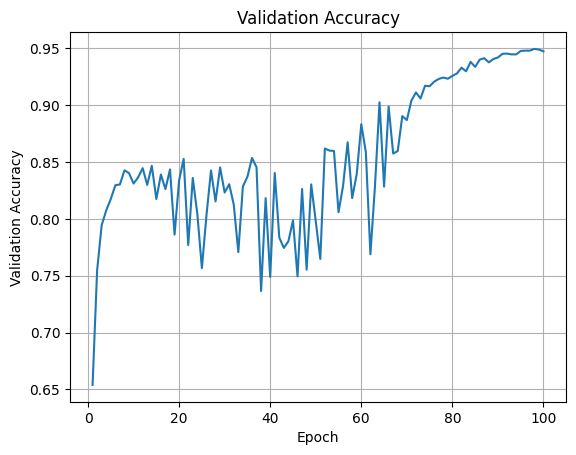

In [ ]:
PATIENCE = 50

loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)
train_model(model, train_loader, test_loader, optimizer, loss, lr_scheduler, device, max_epochs=EPOCHS, patience_limit=PATIENCE)

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_params}")

Total number of parameters: 3351478
